In [ ]:
import os
import re
import random
import numpy as np
import pandas as pd
import torch
import string

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import nltk
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vishalsehgal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vishalsehgal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vishalsehgal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/vishalsehgal/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [35]:
# Load the dataset
data_path = "/Users/vishalsehgal/Desktop/NLP/Assignment-1/Dataset/assignment-2-data.csv"
df = pd.read_csv(data_path)

# Filter articles related to Nvidia
df_nvidia = df[df['clean_content'].str.contains("nvidia", case=False, na=False)].copy()
df_nvidia.reset_index(drop=True, inplace=True)
docs = df_nvidia['clean_content'].tolist()

In [36]:
def preprocess_text_v1(text):
    """
    Original preprocessing function (Preprocessing v1).
    """
    # Check if the text is a string
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase bcoz we dont want to differentiate between words like 'Nvidia' and 'nvidia'
    text = text.lower()
    
    # Remove punctuation except for $ and % bcoz they are important for stock data
    # use nltk punctuation to remove the punctuation
    text = ''.join([char for char in text if char not in string.punctuation or char in ['$','%']])
    
    # Tokenize the text bcoz we want to remove stop words so it helps in breaking the text into words
    # use nltk word_tokenize to tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stop words bcoz they are common words that do not carry much information. I added english and spanish both as US have 2 common languages.
    stop_words_en = set(stopwords.words('english'))
    stop_words_es = set(stopwords.words('spanish'))
    stop_words = stop_words_en.union(stop_words_es)
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize the words bcoz it helps in reducing the words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # remove single words bcoz they are not useful for our analysis as when i checked 50 commonwords there was words like "u" and "p" which makes no sense
    words = [word for word in words if len(word) > 1]
    
    # Remove unwanted numbers bcoz they are not useful for our analysis as we are working on text and we are not removing financial symbols and numbers becasue they are important for stock data
    units = ['million', 'billion', 'trillion', 'thousand', 'hundred']
    processed_words = []
    i = 0
    while i < len(words):
        word = words[i]
        keep_word = True
            # Check if the word is a number
        if word.isdigit():
            keep_word = False
            # Check if previous word is $ or usd
            if i > 0 and words[i - 1] in ['$', 'usd']:
                keep_word = True
             # Check if next word is % or a unit
            elif i + 1 < len(words) and (words[i + 1] in ['%', 'percent'] or words[i + 1] in units):
                keep_word = True
            # Check if word contains $ or %
            elif '$' in word or '%' in word:
                keep_word = True
        if keep_word:
            processed_words.append(word)
        i += 1
    # Join the words back into a string 
    clean_text = ' '.join(processed_words)
    return clean_text


In [37]:
# added custom stop words related to stock market 
# also added some more stop words which are repeating 95% of the time in the text and only once (added this after 1st iteration)
custom_stop_words = [
    "quarter", "week", "today", "period", "session", "billion", "million", "percent", "index",
    "investment", "earnings", "revenue", "growth", "rate", "high", "volume", "stock", "target",
    "price", "analyst", "market", "fund", "asset", "allocation", "solution", "client", "report",
    "forecast", "record", "technology", "industry", "system", "platform", "device", "company",
    "digital", "sector", "day", "seven", "one", "said",
    "traded", "gmt", "exchange", "lowest", "highest", "volume", "session", "start", "range",
    "investing", "com", "rose", "fell", "trade", "today", "yesterday", "week", "monday", "tuesday",
    "wednesday", "thursday", "friday", "nasdaq", "nyse"
]


In [38]:
def preprocess_text_v2(text):
    """
    Preprocessing v2: Preprocessing v1 + custom stop words 
    """
    text = preprocess_text_v1(text)
    words = nltk.word_tokenize(text)
    custom_stop_words_lower = set([word.lower() for word in custom_stop_words])
    words = [word for word in words if word not in custom_stop_words_lower]
    clean_text = ' '.join(words)
    return clean_text


In [ ]:
def preprocess_text_v3(text):
    """
    Preprocessing v2: Preprocessing v2 + spellcheck and meaning words.
    """

    text = preprocess_text_v2(text)

    # spell checker and vocabulary of English words as in assignment it is mentioned that if topics contains typos or meaning less words.
    spell = SpellChecker()
    english_vocab = set(w.lower() for w in words.words())
    
    # lowercasing and removing special characters
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Token
    tokens = text.split()
    corrected_tokens = []
    for token in tokens:
        # Check if the token is a known English word
        if token in english_vocab:
            corrected_tokens.append(token)
        else:
            # correct the spelling
            corrected_token = spell.correction(token)
            # Add the corrected token if it is in the English vocabulary
            if corrected_token in english_vocab:
                corrected_tokens.append(corrected_token)
            else:
                # discard the token if not in English vocabulary
                continue
    # Reconstruct
    cleaned_text = ' '.join(corrected_tokens)
    return cleaned_text

In [40]:
# Define the grid of number of topics
num_topics_grid = [40, 50, 55, 56, 57, 58, 59, 60, 70, 80, 90, 100]
coherence_scores = []
diversity_scores = []

Also checked till 500 (same parameters as in other models code) but 50 was best at that time but i wanted exact number so i checked 40 to 60 and came out 56 is best because of coherence score and more diversity. 
But it was changing so i added seed and to make it fix and now 50 is better becasue of high coherence and almost similar diversity as 56. You will see it later in code.

In [41]:
# used seed to get the same results everytime
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [42]:
# umap model for dimensionality reduction and used cosine similarity as we are working on text data
def create_umap_model():
    return UMAP(
        random_state=42,
        n_neighbors=15,
        min_dist=0.1,
        metric='cosine',
        n_jobs=1
    )

In [43]:
# i used hdbscan model for clustering as it is good for clustering and it is also good for outlier detection
def create_hdbscan_model():
    return HDBSCAN(
        min_cluster_size=10,
        min_samples=10,
        prediction_data=True,
        core_dist_n_jobs=1
    )

In [44]:
def create_bertopic_model(umap_model, hdbscan_model, vectorizer_model, min_topic_size=10, nr_topics=None):
    return BERTopic(
        vectorizer_model=vectorizer_model,
        min_topic_size=min_topic_size,
        calculate_probabilities=True,
        embedding_model='all-MiniLM-L6-v2',
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics= nr_topics,
    )

i did some research on bertopic and found there are multiple embedding models after trying some other models like "paraphrase mini" found that "all-MiniLM-L6-v2" (even though it is same as the one done in the class just with some extra confighuration) but have better speed and accuracy compare to other so i decided to use this. 

In [45]:
# Calculate topic coherence
def calculate_coherence(bert_topic, docs):
    texts = [doc.split() for doc in docs]
    dictionary = Dictionary(texts)
    topics = [[word for word, _ in bert_topic.get_topic(topic_id)] for topic_id in bert_topic.get_topics().keys()]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Calculate topic diversity
def calculate_diversity(bert_topic, top_n=10):
    topics = bert_topic.get_topics()
    unique_words = set()
    total_words = 0
    for topic_id in topics:
        words = [word for word, _ in topics[topic_id][:top_n]]
        unique_words.update(words)
        total_words += len(words)
    return len(unique_words) / total_words

# calculate interpretability score (using coherence as a proxy)
def calculate_interpretability(topic_model):
    return calculate_coherence(topic_model, docs)


# Display topics
def display_topics(bert_topic, iteration):
    print(f"\nTopics for Iteration {iteration}:")
    topic_info = bert_topic.get_topic_info()
    for topic_num in topic_info['Topic'].unique():
        if topic_num == -1:
            continue
        print(f"\nTopic {topic_num}:")
        for word, score in bert_topic.get_topic(topic_num):
            print(f"{word}: {score:.4f}")


In [46]:
# I took this from Bram's code (FLSA-W) and made it for bertopic.

# Iterate over the parameters
for num_topics in num_topics_grid:
    print(f"\nTraining BERTopic model with num_topics={num_topics}")
    set_seeds(42)

    # Initialize BERTopic
    topic_model = BERTopic(
        nr_topics=num_topics,
        calculate_probabilities=True,
        verbose=False,
        vectorizer_model=CountVectorizer(stop_words="english"),
        umap_model=create_umap_model(),
        hdbscan_model=create_hdbscan_model()
    )

    # Fit the model
    topics, probabilities = topic_model.fit_transform(docs)

    # Get vocabulary size
    vocab_size = len(topic_model.vectorizer_model.vocabulary_)
    print("Vocabulary Size:", vocab_size)

    # Get topic-word matrix (pwgt)
    pwgt = topic_model.c_tf_idf_
    print("Topic-Word Matrix Shape:", pwgt.shape)

    # Get document-topic matrix (ptgd)
    ptgd = probabilities 
    print("Document-Topic Matrix Shape:", ptgd.shape)

    # Show topics
    print(f"Topics for num_topics={num_topics}:")
    for topic_num in topic_model.get_topics().keys():
        if topic_num == -1:
            continue  
        print(f"\nTopic {topic_num}:")
        for word, score in topic_model.get_topic(topic_num):
            print(f"{word}: {score:.4f}")

    # Calculate scores
    coherence_score = calculate_coherence(topic_model, docs)
    diversity_score = calculate_diversity(topic_model)
    interpretability_score = calculate_interpretability(topic_model)

    print("\nCoherence Score:", coherence_score)
    print("Diversity Score:", diversity_score)
    print("Interpretability Score:", interpretability_score)

    coherence_scores.append(coherence_score)
    diversity_scores.append(diversity_score)

# After iteration, you can analyze the scores
print("\nNumber of Topics Grid:", num_topics_grid)
print("Coherence Scores:", coherence_scores)
print("Diversity Scores:", diversity_scores)


Training BERTopic model with num_topics=40
Vocabulary Size: 29251
Topic-Word Matrix Shape: (40, 29251)
Document-Topic Matrix Shape: (3043, 39)
Topics for num_topics=40:

Topic 0:
million: 0.0295
quarter: 0.0283
year: 0.0252
revenue: 0.0242
zacks: 0.0214
company: 0.0214
rank: 0.0157
earnings: 0.0156
cent: 0.0155
consensus: 0.0154

Topic 1:
nyse: 0.0188
nasdaq: 0.0163
trade: 0.0158
point: 0.0155
oil: 0.0151
dow: 0.0141
week: 0.0134
market: 0.0132
future: 0.0128
index: 0.0126

Topic 2:
traded: 0.3452
seven: 0.1525
nvidia: 0.1521
gmt: 0.1519
lowest: 0.1489
day: 0.1481
highest: 0.1380
exchange: 0.1293
volume: 0.1263
session: 0.1203

Topic 3:
nvidia: 0.0363
gaming: 0.0233
year: 0.0220
quarter: 0.0208
revenue: 0.0199
billion: 0.0197
company: 0.0175
fiscal: 0.0161
share: 0.0150
estimate: 0.0150

Topic 4:
zacks: 0.0215
analyst: 0.0206
growth: 0.0156
stock: 0.0155
company: 0.0150
year: 0.0146
research: 0.0141
report: 0.0135
fund: 0.0130
earnings: 0.0124

Topic 5:
amd: 0.0810
graphic: 0.0297
rad

50 is the best because of high coherence score and more diverstiy. 

# 1st iteration with preprocessing v1 (older preprocessing function used in assignment 1). 


In [47]:
# Nr_topics = 50 

def iteration_1(df_nvidia):
    print("\n--- Iteration 1: Initial Model with topics and preprocessing text form assignment 1 ---")
    set_seeds()
    
    # Preprocessing using preprocess_text_v1
    df_nvidia['Cleaned_Content'] = df_nvidia['clean_content'].apply(preprocess_text_v1)
    docs = df_nvidia['Cleaned_Content'].tolist()
    
    # Initialize models
    umap_model = create_umap_model()
    hdbscan_model = create_hdbscan_model()
    vectorizer_model = CountVectorizer(lowercase=True)
    bert_topic = create_bertopic_model(umap_model, hdbscan_model, vectorizer_model, min_topic_size=10,nr_topics=50)
    
    # Fit the model
    topics, probabilities = bert_topic.fit_transform(docs)
    
    # Evaluate
    coherence = calculate_coherence(bert_topic, docs)
    diversity = calculate_diversity(bert_topic)
    print("Topic Coherence Score:", coherence)
    print("Topic Diversity Score:", diversity)
    
    # Display topics
    display_topics(bert_topic, iteration=1)
    
    return bert_topic, docs, topics, probabilities

# 2nd iteration with preprocessing v2 (preprocesing v1 + custom stop words)

In [48]:
# i also incudle more stop word as i saw some words are repeating 95% of the time and only once in the text
# Nr_topics = 50

def iteration_2(df_nvidia):
    print("\n--- Iteration 2: Improved Preprocessing with Custom Stop Words ---")
    set_seeds()
    
    # Preprocessing using the updated function
    df_nvidia['Cleaned_Content'] = df_nvidia['clean_content'].apply(preprocess_text_v2)
    docs = df_nvidia['Cleaned_Content'].tolist()
    
    # Initialize models
    umap_model = create_umap_model()
    hdbscan_model = create_hdbscan_model()
    vectorizer_model = CountVectorizer(lowercase=True)
    bert_topic = create_bertopic_model(umap_model, hdbscan_model, vectorizer_model, nr_topics=50)
    
    # Fit the model
    topics, probabilities = bert_topic.fit_transform(docs)
    
    # Evaluate
    coherence = calculate_coherence(bert_topic, docs)
    diversity = calculate_diversity(bert_topic)
    print("Topic Coherence Score:", coherence)
    print("Topic Diversity Score:", diversity)
    
    # Display topics
    display_topics(bert_topic, iteration=2)
    
    return bert_topic, docs, topics, probabilities

# 3rd iteration with preprocessing v3 (preprocessing v2 + 30 min topic size)

In [49]:
def iteration_3(df_nvidia):
    print("\n--- Iteration 3: Adjusted Model Parameters ---")
    set_seeds()
    
    # Preprocessing
    df_nvidia['Cleaned_Content'] = df_nvidia['clean_content'].apply(preprocess_text_v2)
    docs = df_nvidia['Cleaned_Content'].tolist()
    
    # Initialize models
    umap_model = create_umap_model()
    hdbscan_model = create_hdbscan_model()
    vectorizer_model = CountVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        lowercase=True
    )
    bert_topic = create_bertopic_model(umap_model, hdbscan_model, vectorizer_model, min_topic_size=30, nr_topics=50)
    
    # Fit the model
    topics, probabilities = bert_topic.fit_transform(docs)
    
    # Evaluate
    coherence = calculate_coherence(bert_topic, docs)
    diversity = calculate_diversity(bert_topic)
    print("Topic Coherence Score:", coherence)
    print("Topic Diversity Score:", diversity)
    
    # Display topics
    display_topics(bert_topic, iteration=3)
    
    return bert_topic, docs, topics, probabilities

# 4th Iteration with TF-IDF

In [50]:
def iteration_4(df_nvidia):
    print("\n--- Iteration 4: Adjusted Model Parameters with TF-IDF ---")
    set_seeds()
    
    # Preprocessing
    df_nvidia['Cleaned_Content'] = df_nvidia['clean_content'].apply(preprocess_text_v2)
    docs = df_nvidia['Cleaned_Content'].tolist()
    
    # Initialize models
    umap_model = create_umap_model()
    hdbscan_model = create_hdbscan_model()
    
    # Use TfidfVectorizer instead of CountVectorizer
    vectorizer_model = TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        lowercase=True
    )
    
    bert_topic = create_bertopic_model(umap_model=umap_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, min_topic_size=30, nr_topics=50
    )
    
    # Fit the model
    topics, probabilities = bert_topic.fit_transform(docs)
    
    # Evaluate
    coherence = calculate_coherence(bert_topic, docs)
    diversity = calculate_diversity(bert_topic)
    print("Topic Coherence Score:", coherence)
    print("Topic Diversity Score:", diversity)
    
    # Display topics
    display_topics(bert_topic, iteration=4)
    
    return bert_topic, docs, topics, probabilities

# 5th Iteration TFIDF + typo/meaningless words

not using this as it decrease the topic to 3 topics and took 1+ hrs to run

In [51]:
if __name__ == "__main__":
    # Iteration 1
    bert_topic1, docs1, topics1, probabilities1 = iteration_1(df_nvidia)
    
    # Iteration 2
    bert_topic2, docs2, topics2, probabilities2 = iteration_2(df_nvidia)
    
    # Iteration 3
    bert_topic3, docs3, topics3, probabilities3 = iteration_3(df_nvidia)

    # Iteration 4
    bert_topic4, docs4, topics4, probabilities4 = iteration_4(df_nvidia)


--- Iteration 1: Initial Model with topics and preprocessing text form assignment 1 ---
Topic Coherence Score: 0.6111278426290753
Topic Diversity Score: 0.534

Topics for Iteration 1:

Topic 0:
nyse: 0.0155
trade: 0.0135
nasdaq: 0.0130
week: 0.0124
dow: 0.0121
point: 0.0117
market: 0.0116
index: 0.0115
oil: 0.0114
china: 0.0111

Topic 1:
nvidia: 0.0312
gaming: 0.0188
quarter: 0.0176
year: 0.0174
revenue: 0.0161
billion: 0.0152
company: 0.0145
estimate: 0.0130
fiscal: 0.0130
share: 0.0129

Topic 2:
million: 0.0334
quarter: 0.0291
year: 0.0251
revenue: 0.0243
zacks: 0.0221
company: 0.0193
cent: 0.0183
consensus: 0.0167
rank: 0.0163
earnings: 0.0157

Topic 3:
amd: 0.0795
graphic: 0.0293
radeon: 0.0270
gpu: 0.0243
processor: 0.0238
ryzen: 0.0199
card: 0.0167
year: 0.0165
micro: 0.0157
epyc: 0.0156

Topic 4:
resistance: 0.0464
around: 0.0337
stock: 0.0285
towards: 0.0279
break: 0.0268
roku: 0.0262
nasdaq: 0.0236
rise: 0.0224
higher: 0.0222
support: 0.0211

Topic 5:
vehicle: 0.0535
driving:

We are declining iteration 5 as the number of topic is decreased to 3 topics and too much computational power needed

## Labels Given by ChatGPT for Iteration 4

https://chatgpt.com/share/672a159f-e788-8003-a67a-324149ff7ef4

Based on the most prominent keywords and terms in each topic, here are suggested labels:

---

- **Topic 0:** "Nvidia Stock Performance History"
- **Topic 1:** "Technical Analysis Metrics (e.g., AT40, T2108)"
- **Topic 2:** "Historical Nvidia Stock Metrics"
- **Topic 3:** "Western Digital and Sandisk Storage"
- **Topic 4:** "Therapeutics and Stock Movements"
- **Topic 5:** "Nvidia Market Trends Over Time"
- **Topic 6:** "Nvidia Stock Volatility and Trading Metrics"
- **Topic 7:** "Bitcoin and Cryptocurrency Trends"
- **Topic 8:** "Qualcomm and Antitrust Issues"
- **Topic 9:** "Pure Storage and Cloud Solutions"
- **Topic 10:** "Stock Performance Close and Settling"
- **Topic 11:** "PEG Ratio and Valuation Metrics"
- **Topic 12:** "Mellanox Technologies and Ethernet Solutions"
- **Topic 13:** "Autonomous Driving and Tesla"
- **Topic 14:** "Huawei, Trade Tariffs, and Chinese Tech"
- **Topic 15:** "Nvidia Gaming and Graphics"
- **Topic 16:** "Zacks Free Lunch Podcast"
- **Topic 17:** "AMD and Processor Developments"
- **Topic 18:** "Micron and DRAM/NAND Memory"
- **Topic 19:** "Artificial Intelligence and Robotics"
- **Topic 20:** "Intel and Semiconductor Industry"
- **Topic 21:** "Qualcomm, Broadcom, and Mobile Devices"
- **Topic 22:** "Apple and iPhone Market"
- **Topic 23:** "Semiconductor ETFs and Rankings"
- **Topic 24:** "Tracey Ryniec's Portfolio Insights"
- **Topic 25:** "Tesla and Premarket Focus"
- **Topic 26:** "Cadence Design and Protium Verification"
- **Topic 27:** "Quarterly Earnings and EPS Beats"
- **Topic 28:** "Market Movements and Reuters Insights"
- **Topic 29:** "Facebook and Social Media Advertising"
- **Topic 30:** "Texas Instruments and Financial Metrics"
- **Topic 31:** "China, Resistance Levels, and Trading"
- **Topic 32:** "Roku Stock and Market Resistance Levels"
- **Topic 33:** "Tech ETFs and FANG Stocks"
- **Topic 34:** "General Investment Insights and ETF Rankings"
- **Topic 35:** "Oil Prices and RSI Indicators"
- **Topic 36:** "European Currencies and Market Yields"
- **Topic 37:** "NetApp and Cloud Computing"
- **Topic 38:** "Microsoft, Azure, and Cloud Services"
- **Topic 39:** "Zacks Research and Investment Highlights"
- **Topic 40:** "Zacks ESP Rank and Earnings Surprise"
- **Topic 41:** "SaaS Software and Human Capital Management"
- **Topic 42:** "Financials and Yearly Cash Flow"
- **Topic 43:** "Dow, Banking, and Oil Projections"
- **Topic 44:** "Inflation, Fed Policies, and Economic Indicators"
- **Topic 45:** "Future Market Projections and Dollar Strength"
- **Topic 46:** "China Tariffs and Trade Exposure"
- **Topic 47:** "Fed Announcements and Trump News"
- **Topic 48:** "Job Market and Investor Gains"

--- 

These labels can help give a quick understanding of each topic’s core focus based on the most representative terms. Let me know if you need further refinements!

In [52]:
# Added labels to the topic coz it look good on similarity matrix

num_topics = len(bert_topic4.get_topics())
custom_labels = [
    " ",
    "Nvidia Stock Performance History",
    "Technical Analysis Metrics (e.g., AT40, T2108)",
    "Historical Nvidia Stock Metrics",
    "Western Digital and Sandisk Storage",
    "Therapeutics and Stock Movements",
    "Nvidia Market Trends Over Time",
    "Nvidia Stock Volatility and Trading Metrics",
    "Bitcoin and Cryptocurrency Trends",
    "Qualcomm and Antitrust Issues",
    "Pure Storage and Cloud Solutions",
    "Stock Performance Close and Settling",
    "PEG Ratio and Valuation Metrics",
    "Mellanox Technologies and Ethernet Solutions",
    "Autonomous Driving and Tesla",
    "Huawei, Trade Tariffs, and Chinese Tech",
    "Nvidia Gaming and Graphics",
    "Zacks Free Lunch Podcast",
    "AMD and Processor Developments",
    "Micron and DRAM/NAND Memory",
    "Artificial Intelligence and Robotics",
    "Intel and Semiconductor Industry",
    "Qualcomm, Broadcom, and Mobile Devices",
    "Apple and iPhone Market",
    "Semiconductor ETFs and Rankings",
    "Tracey Ryniec's Portfolio Insights",
    "Tesla and Premarket Focus",
    "Cadence Design and Protium Verification",
    "Quarterly Earnings and EPS Beats",
    "Market Movements and Reuters Insights",
    "Facebook and Social Media Advertising",
    "Texas Instruments and Financial Metrics",
    "China, Resistance Levels, and Trading",
    "Roku Stock and Market Resistance Levels",
    "Tech ETFs and FANG Stocks",
    "General Investment Insights and ETF Rankings",
    "Oil Prices and RSI Indicators",
    "European Currencies and Market Yields",
    "NetApp and Cloud Computing",
    "Microsoft, Azure, and Cloud Services",
    "Zacks Research and Investment Highlights",
    "Zacks ESP Rank and Earnings Surprise",
    "SaaS Software and Human Capital Management",
    "Financials and Yearly Cash Flow",
    "Dow, Banking, and Oil Projections",
    "Inflation, Fed Policies, and Economic Indicators",
    "Future Market Projections and Dollar Strength",
    "China Tariffs and Trade Exposure",
    "Fed Announcements and Trump News",
    "Job Market and Investor Gains"
]

# Truncate or extend the custom_labels list to match the number of topics
if len(custom_labels) > num_topics:
    custom_labels = custom_labels[:num_topics]
else:
    custom_labels.extend(["Topic " + str(i + 1) for i in range(len(custom_labels), num_topics)])

# Assign updated custom labels to topics
bert_topic4.set_topic_labels(custom_labels)


In [53]:
bert_topic4.visualize_topics(custom_labels=True).show()
bert_topic4.visualize_heatmap(custom_labels=True).show()


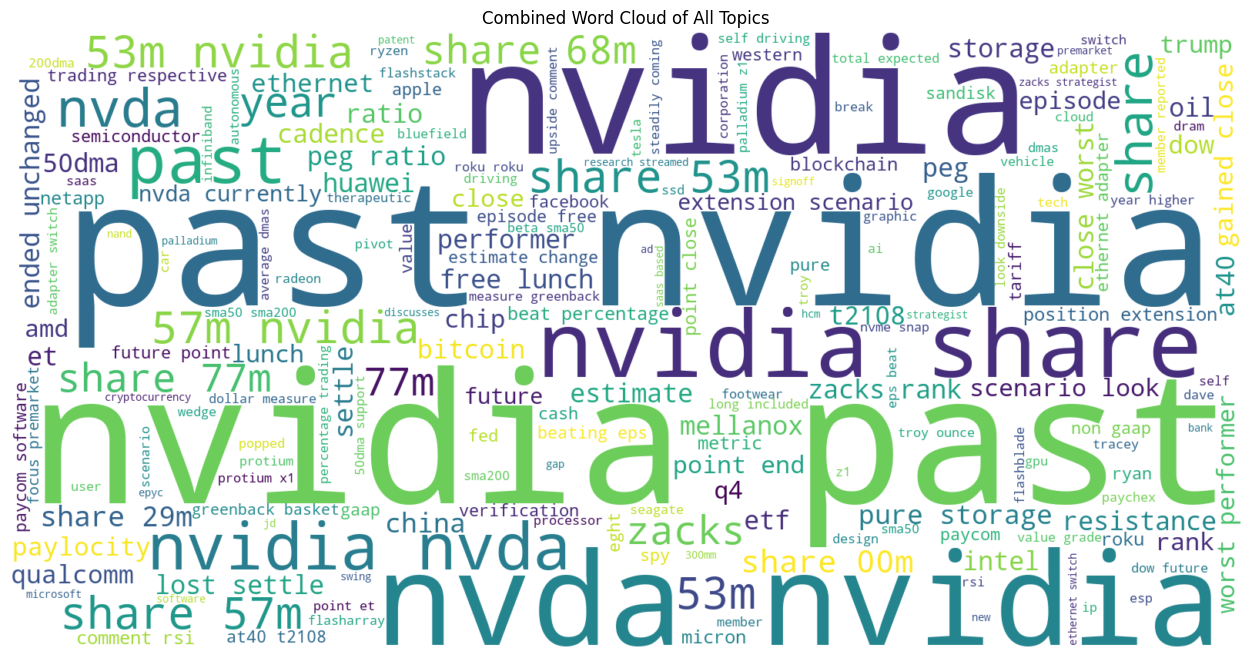

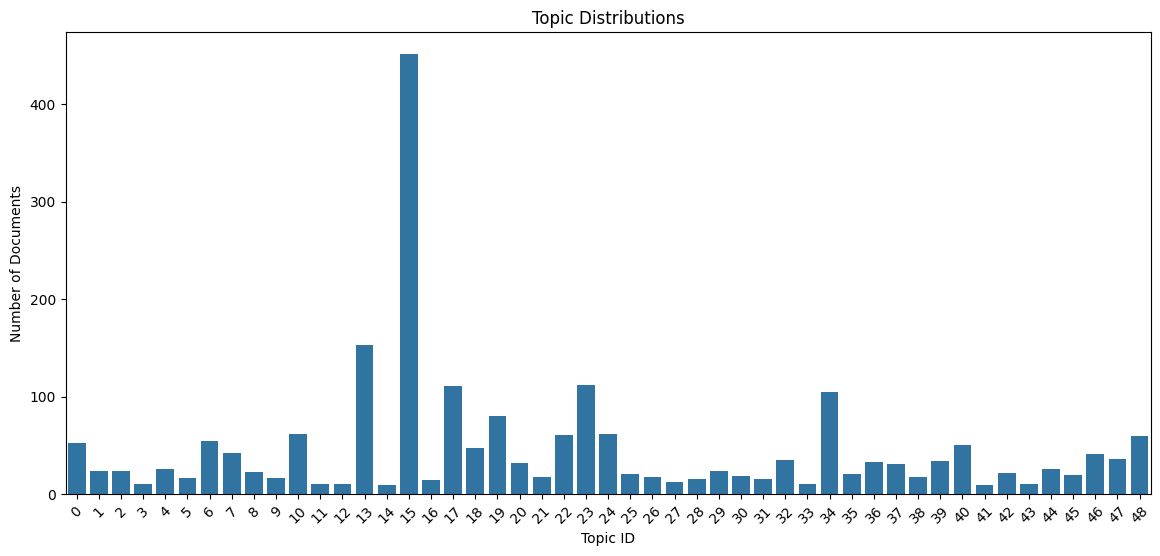

In [ ]:
# Function to create a combined word cloud for all topics
def create_combined_wordcloud(bert_topic, custom_labels):
    combined_words = {}
    topics = bert_topic.get_topics()
    
    # Combine words and their weights from all topics
    for topic_id, topic_data in topics.items():
        for word, weight in topic_data:
            if word in combined_words:
                combined_words[word] += weight
            else:
                combined_words[word] = weight
    
    # Generate the word cloud for combined words
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(combined_words)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Combined Word Cloud of All Topics')
    plt.show()

# Function to plot the distribution of topics
def plot_topic_distributions(bert_topic):
    # Get topic sizes information
    topic_sizes = bert_topic.get_topic_info()[['Topic', 'Count']]
    topic_sizes = topic_sizes[topic_sizes['Topic'] >= 0]  # Exclude outlier or non-topic entries
    
    # Plot topic distributions
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Topic', y='Count', data=topic_sizes)
    plt.xlabel('Topic ID')
    plt.ylabel('Number of Documents')
    plt.title('Topic Distributions')
    plt.xticks(rotation=45)
    plt.show()


# Call the functions with your BERTopic model
create_combined_wordcloud(bert_topic4, custom_labels)
plot_topic_distributions(bert_topic4)


The topic distribution plot shows the number of documents associated with each topic.
This helps in understanding how prevalent or significant each topic is within the dataset.
A higher count indicates a more dominant topic in the corpus, while lower counts point to less common topics.